<a href="https://colab.research.google.com/github/alwanfa/neural-network-exploration/blob/main/DUDL_cc_dataInbalanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COURSE: A deep understanding of deep learning
## SECTION: Metaparameters (activation, batch, optimizers)
### LECTURE: CodeChallenge: Compare relu variants
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

## Experimental Analysis about performance model on unbalance data on wine dataset quality

In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import and process the data

In [22]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers
data

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)



# note: use the following lines to avoid the warning message
# tmp = (data['quality']>qualThreshold ).astype(int)
# data['boolQuality'] = tmp

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,boolQuality
0,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,5,0
1,-0.298673,1.966614,-1.391823,0.049020,0.222827,0.877032,0.654661,0.025923,-0.723652,0.127837,-0.583341,5,0
2,-0.298673,1.295976,-1.185980,-0.165951,0.095334,-0.081247,0.246069,0.132100,-0.334209,-0.049176,-0.583341,5,0
3,1.653579,-1.386577,1.489975,-0.452579,-0.265897,0.110409,0.434650,0.662984,-0.983280,-0.462207,-0.583341,6,1
4,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,-1.217380,0.401792,-0.980138,-0.380922,0.052836,1.547828,-0.068233,-0.982759,0.899027,-0.462207,0.074599,5,0
1595,-1.389638,0.122359,-0.877216,-0.237608,-0.542132,2.218623,0.151778,-0.865964,1.353377,0.599872,0.732539,6,1
1596,-1.159961,-0.101187,-0.722834,-0.165951,-0.244648,1.260344,-0.193954,-0.536815,0.704305,0.540868,0.544556,6,1
1597,-1.389638,0.653281,-0.774295,-0.380922,-0.265897,1.547828,-0.068233,-0.680154,1.677912,0.304850,-0.207376,5,0


<Axes: xlabel='quality'>

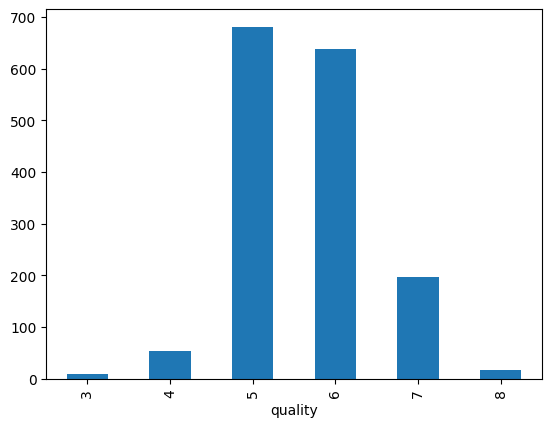

In [30]:
data['quality'].groupby(data['quality']).count().plot.bar()

In [26]:
def defineThreshholdData(data, threshold) :
  data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
  mask = data["quality"] > threshold
  data.loc[mask, 'boolQuality'] = 1
  return data

def displayNumOfcategory(data) :
  data['boolQuality'].groupby(data['boolQuality']).count().plot.bar()


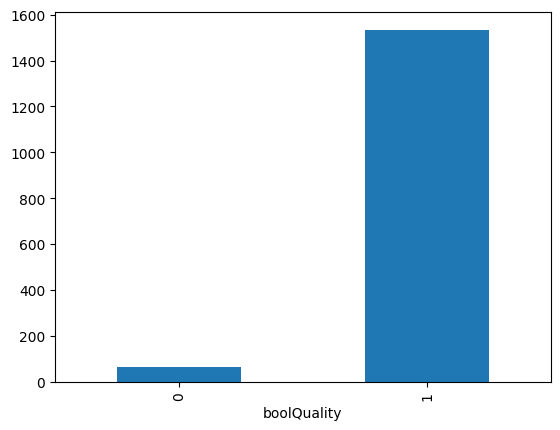

In [39]:
data1 = defineThreshholdData(data, 4.5)
displayNumOfcategory(data1)

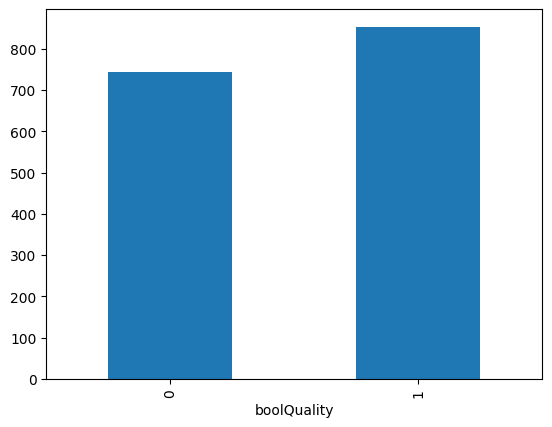

In [40]:
data2 = defineThreshholdData(data, 5.5)
displayNumOfcategory(data2)

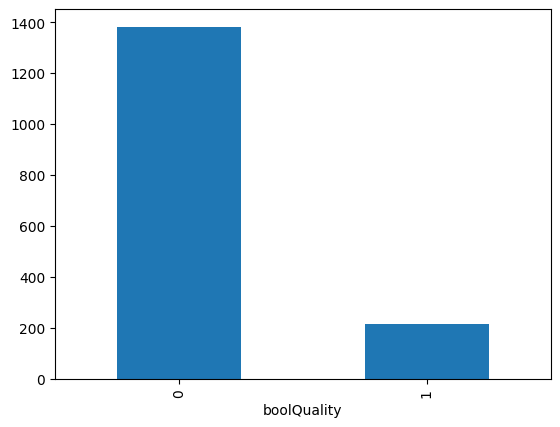

In [41]:
data3 = defineThreshholdData(data, 6.5)
displayNumOfcategory(data3)

# Re-organize the data: train/test in DataLoaders

In [44]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix
labels

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

In [45]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 64
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [46]:
def loaderFormat(data):
  dataT  = torch.tensor( data[cols2zscore].values ).float()
  labels = torch.tensor( data['boolQuality'].values ).float()
  labels = labels[:,None] # transform to matrix
  train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

  # then convert them into PyTorch Datasets (note: already converted to tensors)
  train_data = torch.utils.data.TensorDataset(train_data,train_labels)
  test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

  # finally, translate into dataloader objects
  batchsize    = 64
  train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
  test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])
  return train_loader, test_loader


# Now for the DL part

In [47]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self,actfun):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)

    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

    # activation funcion to pass through
    self.actfun = actfun

  # forward pass
  def forward(self,x):
    # get activation function type
    # this code replaces torch.relu with torch.<self.actfun>
    actfun = getattr(torch.nn,self.actfun)
    x = actfun()( self.input(x) )
    x = actfun()( self.fc1(x) )
    x = actfun()( self.fc2(x) )
    return self.output(x)

# Train the model

In [48]:
# a function that trains the model

# global parameter
numepochs = 500

def trainTheModel(train_loader, test_loader):

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(winenet.parameters(),lr=.001)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses

In [52]:
def calculateCatAcc(test_loader):
  X,y = next(iter(test_loader)) # extract X,y from test dataloader
  itemAccuracy = ((winenet(X)>0) == y).float()
  return [100*torch.mean(itemAccuracy[y==0]),
          100*torch.mean(itemAccuracy[y==1])]

In [53]:
activation_funs = ['LeakyReLU' ]

trainByAct1 = np.zeros((numepochs,len(activation_funs)))
testByAct1 = np.zeros((numepochs,len(activation_funs)))
trainByAct2 = np.zeros((numepochs,len(activation_funs)))
testByAct2  = np.zeros((numepochs,len(activation_funs)))
trainByAct3 = np.zeros((numepochs,len(activation_funs)))
testByAct3  = np.zeros((numepochs,len(activation_funs)))

train_loader1, test_loader1 = loaderFormat(data1)
train_loader2, test_loader2 = loaderFormat(data2)
train_loader3, test_loader3 = loaderFormat(data3)

winenet = ANNwine(activation_funs[0])
trainByAct1[:,0],testByAct1[:,0],losses1 = trainTheModel(train_loader1,test_loader1)
accPercat1 = calculateCatAcc(test_loader1)
winenet = ANNwine(activation_funs[0])
trainByAct2[:,0],testByAct2[:,0],losses2 = trainTheModel(train_loader2,test_loader2)
accPercat2 = calculateCatAcc(test_loader2)
winenet = ANNwine(activation_funs[0])
trainByAct3[:,0],testByAct3[:,0],losses3 = trainTheModel(train_loader3,test_loader3)
accPercat3 = calculateCatAcc(test_loader3)


Text(0.5, 1.0, 'loss')

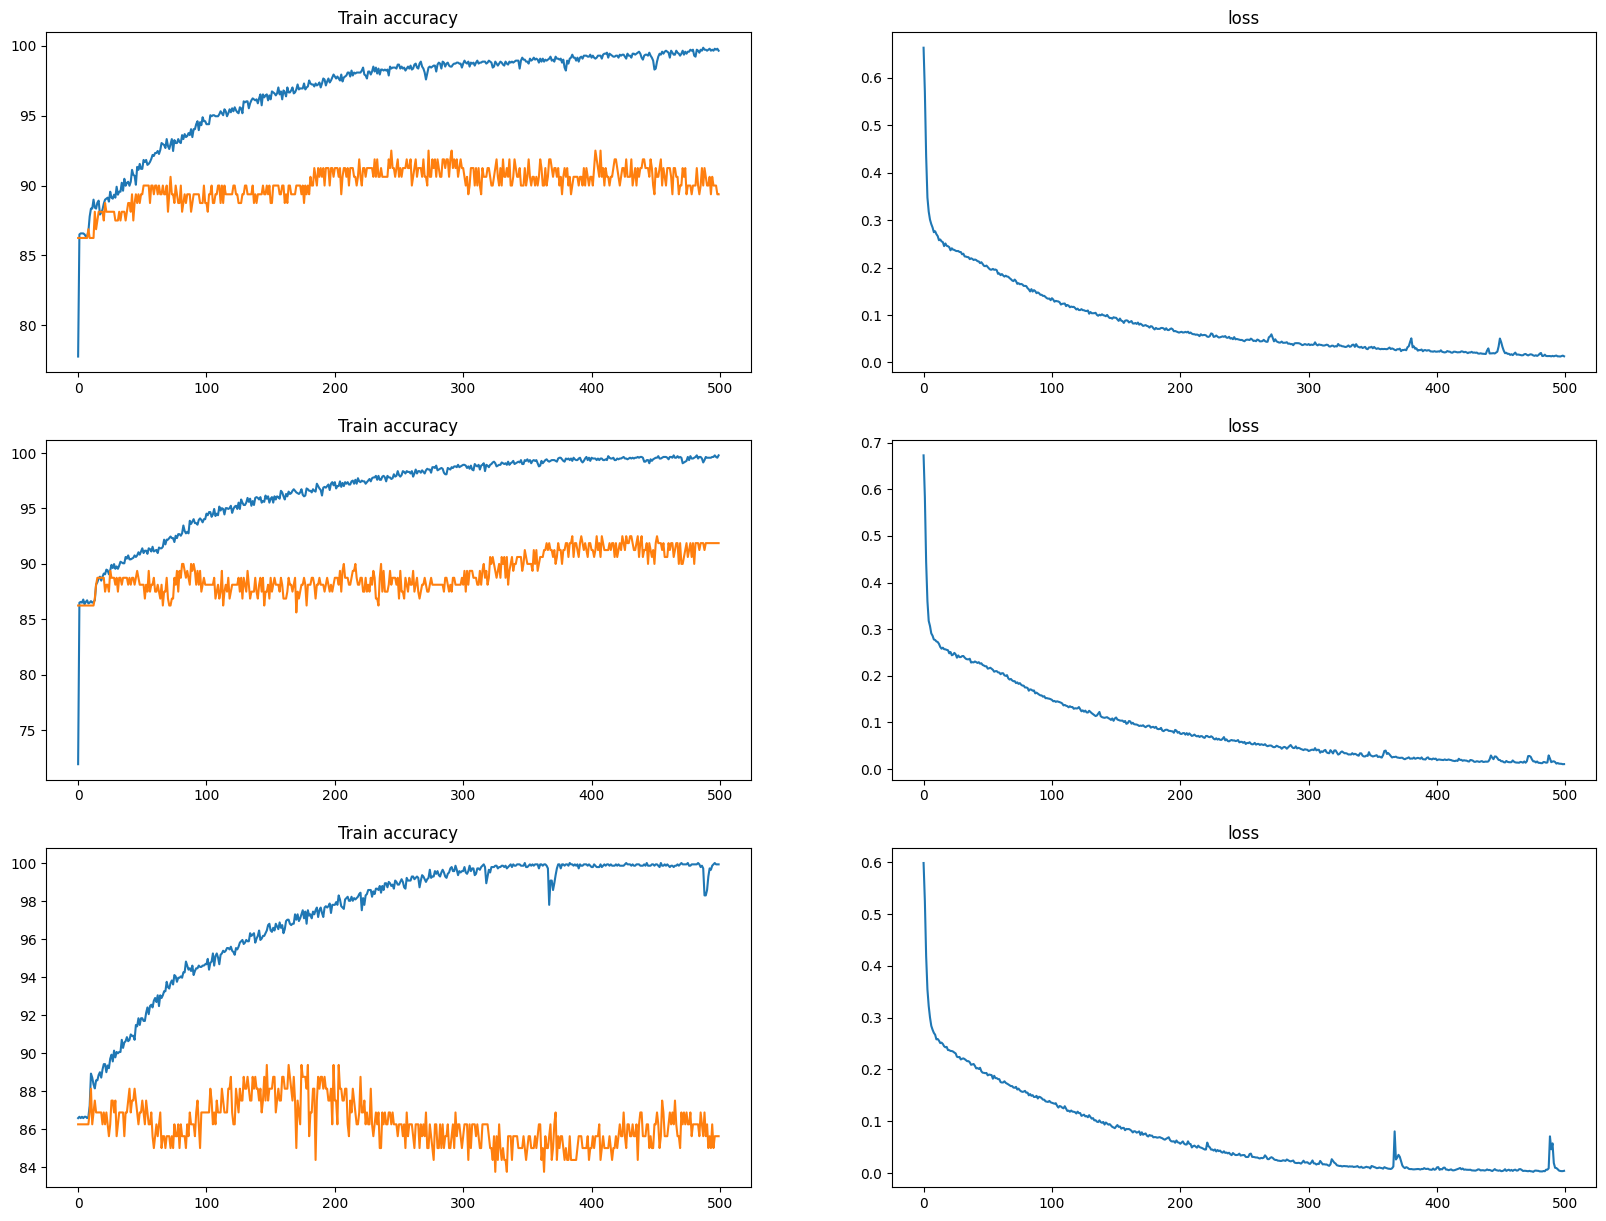

In [38]:
# plot some results
fig,ax = plt.subplots(3,2,figsize=(20,15))


ax[0][0].plot(trainByAct1)
ax[0][0].plot(testByAct1)
ax[0][0].set_title('Train accuracy')

ax[0][1].plot(losses1)
ax[0][1].set_title('loss')


ax[1][0].plot(trainByAct2)
ax[1][0].plot(testByAct2)
ax[1][0].set_title('Train accuracy')

ax[1][1].plot(losses2)
ax[1][1].set_title('loss')


ax[2][0].plot(trainByAct3)
ax[2][0].plot(testByAct3)
ax[2][0].set_title('Train accuracy')
ax[2][1].plot(losses3)
ax[2][1].set_title('loss')


# Additional explorations